# Generalized Additive Models

## Loading the data and the packages

First, the packages

In [30]:
require("CASdatasets") #Not needed if use of dataset.parquet
require("mgcv")
require("caret")
require("plyr")
require("ggplot2")
require("gridExtra")
if (!require("parallel")) install.packages("parallel")
if (!require("mgcViz")) install.packages("mgcViz")
require("parallel")
require("mgcViz")
require("arrow")
require("tidymodels")


Le chargement a nécessité le package : mgcViz

Le chargement a nécessité le package : qgam


Attachement du package : 'qgam'


L'objet suivant est masqué depuis 'package:recipes':

    check


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Registered S3 method overwritten by 'mgcViz':
  method from  
  +.gg   GGally


Attachement du package : 'mgcViz'


L'objet suivant est masqué depuis 'package:lattice':

    qq


Les objets suivants sont masqués depuis 'package:stats':

    qqline, qqnorm, qqplot




then, the data

In [3]:
dataset = read_parquet(file = "../data/dataset.parquet")

Checking that the data is loaded.

In [4]:
str(dataset)

'data.frame':	410864 obs. of  10 variables:
 $ PolicyID : Factor w/ 413169 levels "1","2","3","4",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ ClaimNb  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Exposure : num  0.09 0.84 0.52 0.45 0.15 0.75 0.81 0.05 0.76 0.34 ...
 $ Power    : Factor w/ 12 levels "d","e","f","g",..: 4 4 3 3 4 4 1 1 1 6 ...
 $ CarAge   : int  0 0 2 2 0 0 1 0 9 0 ...
 $ DriverAge: int  46 46 38 38 41 41 27 27 23 44 ...
 $ Brand    : Factor w/ 7 levels "Fiat","Japanese (except Nissan) or Korean",..: 2 2 2 2 2 2 2 2 1 2 ...
 $ Gas      : Factor w/ 2 levels "Diesel","Regular": 1 1 2 2 1 1 2 2 2 2 ...
 $ Region   : Factor w/ 10 levels "Aquitaine","Basse-Normandie",..: 1 1 8 8 9 9 1 1 8 6 ...
 $ Density  : int  76 76 3003 3003 60 60 695 695 7887 27000 ...


# Outline of this session.

- Illustration of the backfitting algorithm
- Use of mgcv package
- When using ‘manual backfitting’ can be useful


# Illustration of the backfitting algorithm

## First iteration

- First we start with a Poisson regression with only an intercept.

In [5]:
autofit=dataset #Copy the data

#Model with only an intercept
require(mgcv) # Load package if not loaded yet.
fit0<-gam(ClaimNb~1, data=autofit, family=poisson(), offset=log(Exposure))

autofit$fit0=fit0$fitted.values
head(autofit$fit0)

[1] 0.006308301 0.058877475 0.036447961 0.031541504 0.010513835 0.052569174

- We fit a model with the discrete variables. (e.g. model from the GLM session, or any other model for the illustration)

In [6]:
fit1<-gam(ClaimNb ~ offset(log(Exposure)) + Power  * Region +  Brand + Gas,
         data = autofit,
         family=poisson(link = log))
autofit$fit1 = fit1$fitted.values

- Let us now consider a continuous covariate: CarAge

In [7]:
require(plyr)
mm <- ddply(autofit, .(CarAge), summarise, totalExposure = sum(Exposure), 
                totalClaimObs=sum(ClaimNb), totalClaimExp=sum(fit1))    
head(mm)

,CarAge,totalExposure,totalClaimObs,totalClaimExp
,<int>,<dbl>,<int>,<dbl>
1,0,8710.903,618,621.9297
2,1,18137.929,1311,1290.4246
3,2,17347.019,1234,1230.6921
4,3,15818.469,1101,1120.1672
5,4,14966.334,1086,1057.8357
6,5,14445.505,1019,1022.4781


In [8]:
fit2<-gam(totalClaimObs ~ s(CarAge), 
              offset=log(totalClaimExp), 
              family=poisson(), 
              data=mm)

- Let us visualize the estimated function.

Le chargement a nécessité le package : visreg



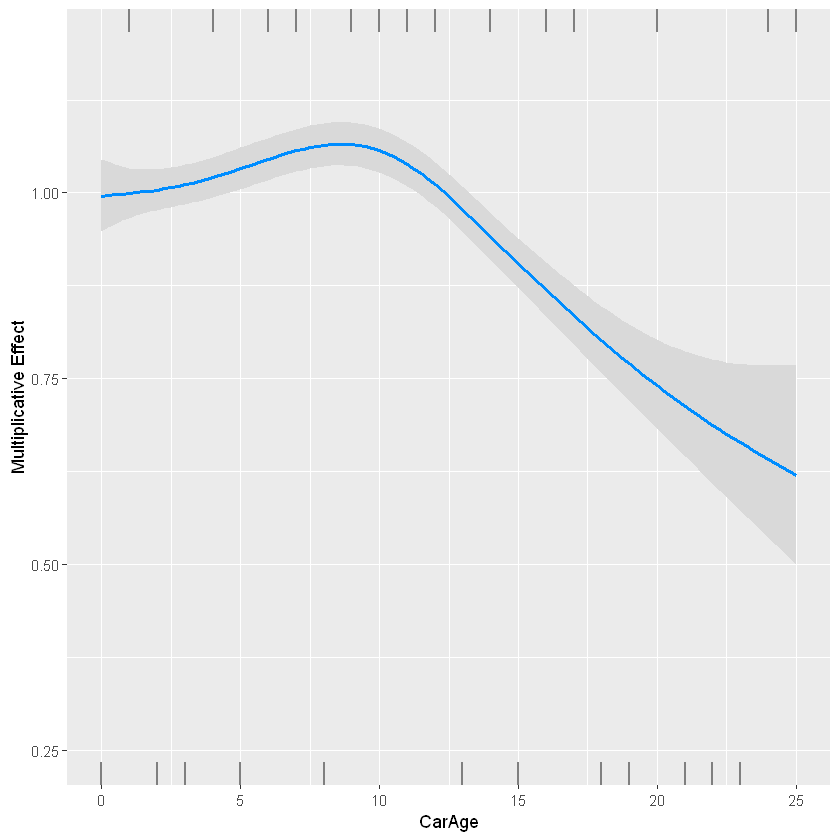

In [9]:
require(visreg)
visreg(fit2, xvar = "CarAge", gg = TRUE, scale = "response") + ylim(c(0.25, 1.2)) +
    ylab("Multiplicative Effect")

The new prediction of the claim frequency is now given by the old one times the correction due to CarAge.

In [10]:
autofit$fit2<-autofit$fit1*predict(fit2, newdata=autofit, type="response")

The total number of predicted claim remains unchanged:

In [11]:
c(sum(autofit$fit1), sum(autofit$fit2))

[1] 16127 16127

- Let us now consider the other continuous covariate: DriverAge

In [12]:
mm <- ddply(autofit, .(DriverAge), summarise, totalExposure = sum(Exposure), totalClaimObs = sum(ClaimNb),
    totalClaimExp = sum(fit2))
head(mm)

,DriverAge,totalExposure,totalClaimObs,totalClaimExp
,<int>,<dbl>,<int>,<dbl>
1,18,148.4220,46,9.951695
2,19,636.9296,171,42.610896
3,20,1020.8744,216,69.527420
4,21,1277.9390,207,87.265481
5,22,1562.9872,239,107.852781
6,23,1830.1058,230,128.854915


In [13]:
fit3 <- gam(totalClaimObs ~ s(DriverAge), offset = log(totalClaimExp), family = poisson(),
    data = mm)

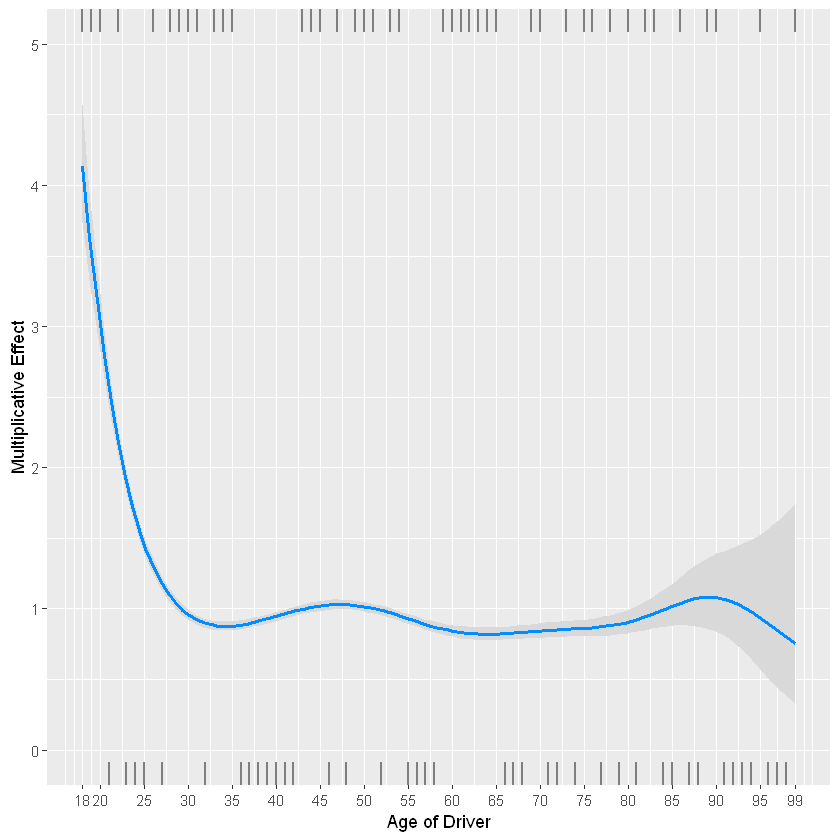

In [14]:
visreg(fit3, xvar = "DriverAge", gg = TRUE, scale = "response") + ylim(c(0, 5)) +
    ylab("Multiplicative Effect") + scale_x_continuous(name = "Age of Driver", limits = c(18,
    99), breaks = c(18, seq(20, 95, 5), 99))

The new prediction of the claim frequency is now given by the old one times the correction due to DriverAge.

In [15]:
autofit$fit3 <- autofit$fit2 * predict(fit3, newdata = autofit, type = "response")

The total expected number of claims remains unchanged.

In [16]:
c(sum(autofit$fit2), sum(autofit$fit3))

[1] 16127 16127

Let us compute the log-likelihood

In [17]:
LL0 = sum(dpois(x = autofit$ClaimNb, lambda = autofit$fit0, log = TRUE))
LLi = sum(dpois(x = autofit$ClaimNb, lambda = autofit$fit3, log = TRUE))
c(LL0, LLi)

[1] -68153.74 -67309.96

## Further iterations

Let us now iterate, and fit again the discrete variables, then CarAge, then DriverAge, and let us stop when the log-likelihood change is smaller than some small epsilon. When we fit the model, everything that has been fitted before and is unrelated to the current variable is put in the offset. To be sure that the algorithm stops, we also put a maximum of 20 iterations...



In [18]:
epsilon = 1e-08
i = 0
fit_it_discr = list(fit1)
fit_it_CarAge = list(fit2)
fit_it_DriverAge = list(fit3)

while (abs(LL0/LLi - 1) > epsilon & (i < 20)) {
    i = i + 1
    LL0 = LLi
    # Discrete variables
    autofit$logoffset = predict(fit_it_CarAge[[i]], newdata = autofit) + predict(fit_it_DriverAge[[i]],
        newdata = autofit) + log(autofit$Exposure)
    fit_it_discr[[i + 1]] <- gam(ClaimNb ~ Power * Region + Brand + Gas, 
                                 autofit, family = poisson(), offset = logoffset)

    # CarAge
    autofit$logoffset = predict(fit_it_discr[[i + 1]], newdata = autofit) + predict(fit_it_DriverAge[[i]],
        newdata = autofit) + log(autofit$Exposure)
    mm <- ddply(autofit, .(CarAge), summarise, totalClaimObs = sum(ClaimNb), totalClaimExp = sum(exp(logoffset)))
    fit_it_CarAge[[i + 1]] <- gam(totalClaimObs ~ s(CarAge), offset = log(totalClaimExp),
        family = poisson(), data = mm)

    # DriverAge
    autofit$logoffset = predict(fit_it_discr[[i + 1]], newdata = autofit) + predict(fit_it_CarAge[[i +
        1]], newdata = autofit) + log(autofit$Exposure)
    mm <- ddply(autofit, .(DriverAge), summarise, totalClaimObs = sum(ClaimNb), totalClaimExp = sum(exp(logoffset)))
    fit_it_DriverAge[[i + 1]] <- gam(totalClaimObs ~ s(DriverAge), offset = log(totalClaimExp),
        family = poisson(), data = mm)
    ## Compute the new estimates

    autofit$currentfit = predict(fit_it_discr[[i + 1]], newdata = autofit, type = "response") *
        predict(fit_it_CarAge[[i + 1]], newdata = autofit, type = "response") * predict(fit_it_DriverAge[[i +
        1]], newdata = autofit, type = "response") * (autofit$Exposure)

    LLi = sum(dpois(x = autofit$ClaimNb, lambda = autofit$currentfit, log = TRUE))
    print(c(i, LL0, LLi))
}

[1]      1.00 -67309.96 -67299.70
[1]      2.00 -67299.70 -67299.33
[1]      3.00 -67299.33 -67299.31
[1]      4.00 -67299.31 -67299.31
[1]      5.00 -67299.31 -67299.31


## Results

Let us now see the betas at each iteration.

### Discrete variables


In [19]:
res_discr = matrix(NA, ncol = 127, nrow = i + 1)
colnames(res_discr) = names(fit_it_discr[[1]]$coefficients)
res_discr[1, ] = fit_it_discr[[1]]$coefficients
res_discr[2, ] = fit_it_discr[[2]]$coefficients
res_discr[3, ] = fit_it_discr[[3]]$coefficients
res_discr[4, ] = fit_it_discr[[4]]$coefficients
res_discr[5, ] = fit_it_discr[[5]]$coefficients
res_discr[6, ] = fit_it_discr[[6]]$coefficients

For instance, the 9 first variables:

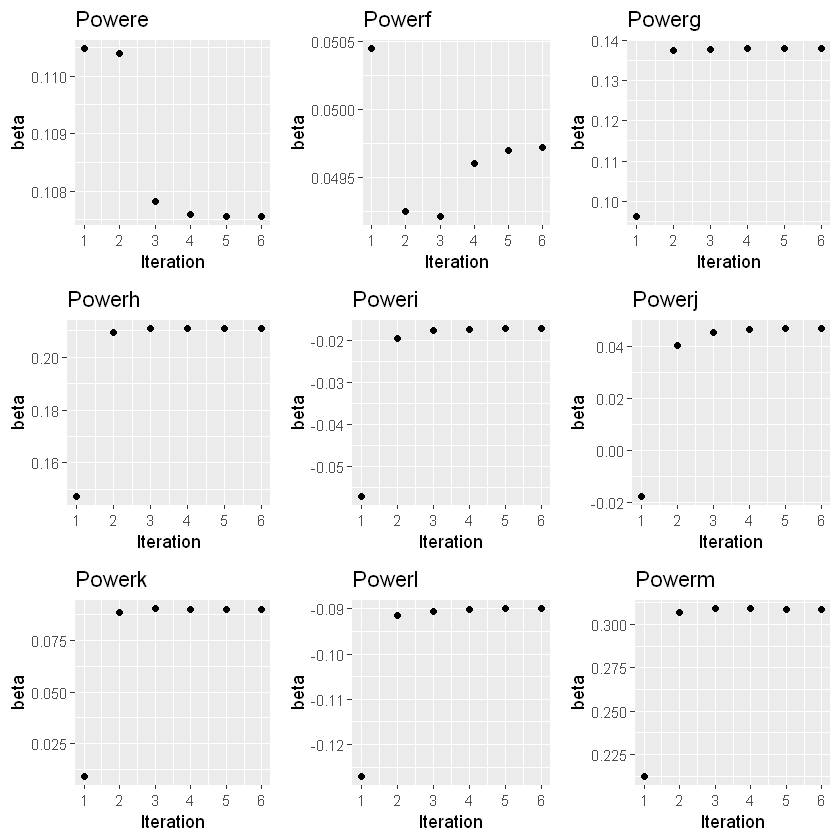

In [20]:
require("gridExtra")
p1 = lapply(2:10, function(i) {
    ggplot() + geom_point(aes(y = res_discr[, i], x = 1:6)) + xlab("Iteration") +
        ylab("beta") + ggtitle(names(fit_it_discr[[1]]$coefficients)[i]) + scale_x_continuous(breaks = 1:6)
})
do.call(grid.arrange, p1)

### CarAge

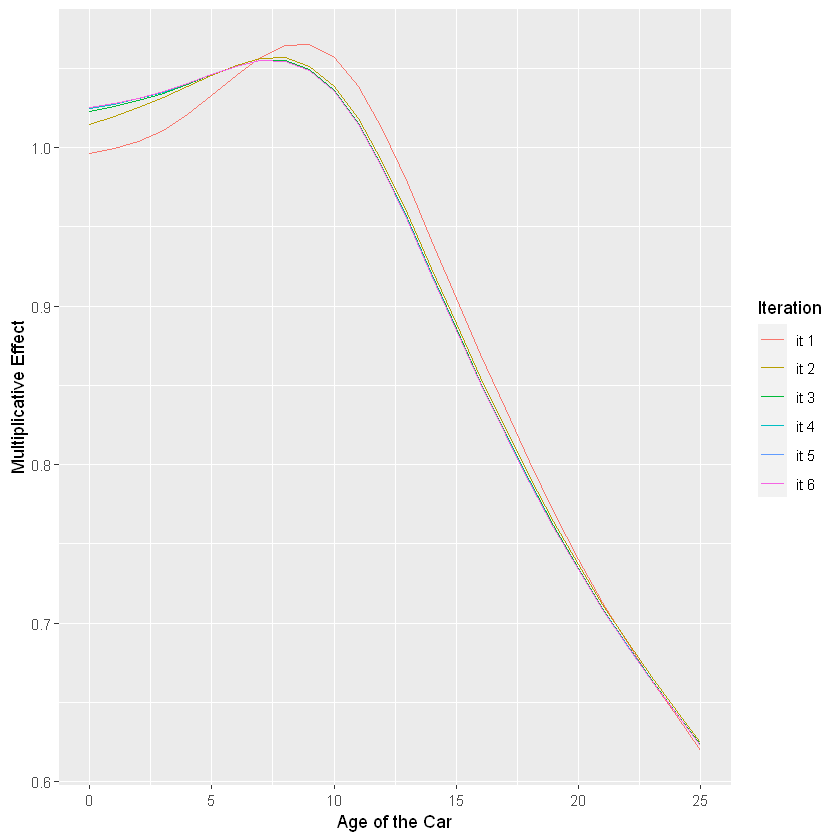

In [21]:
CarAge = matrix(NA, ncol = 6, nrow = 26)
CarAge[, 1] = predict(fit_it_CarAge[[1]], data.frame(CarAge = seq(from = 0, to = 25,
    by = 1)), type = "response")
CarAge[, 2] = predict(fit_it_CarAge[[2]], data.frame(CarAge = seq(from = 0, to = 25,
    by = 1)), type = "response")
CarAge[, 3] = predict(fit_it_CarAge[[3]], data.frame(CarAge = seq(from = 0, to = 25,
    by = 1)), type = "response")
CarAge[, 4] = predict(fit_it_CarAge[[4]], data.frame(CarAge = seq(from = 0, to = 25,
    by = 1)), type = "response")
CarAge[, 5] = predict(fit_it_CarAge[[5]], data.frame(CarAge = seq(from = 0, to = 25,
    by = 1)), type = "response")
CarAge[, 6] = predict(fit_it_CarAge[[6]], data.frame(CarAge = seq(from = 0, to = 25,
    by = 1)), type = "response")

x = as.data.frame(CarAge)
names(x) = sapply(1:6, function(i) {
    paste("it", i)
})
x = stack(as.data.frame(x))
names(x)[2] = "Iteration"

ggplot(x) + geom_line(aes(x = rep(0:25, 6), y = values, color = Iteration)) + xlab("Age of the Car") +
    ylab("Multiplicative Effect")

### DriverAge


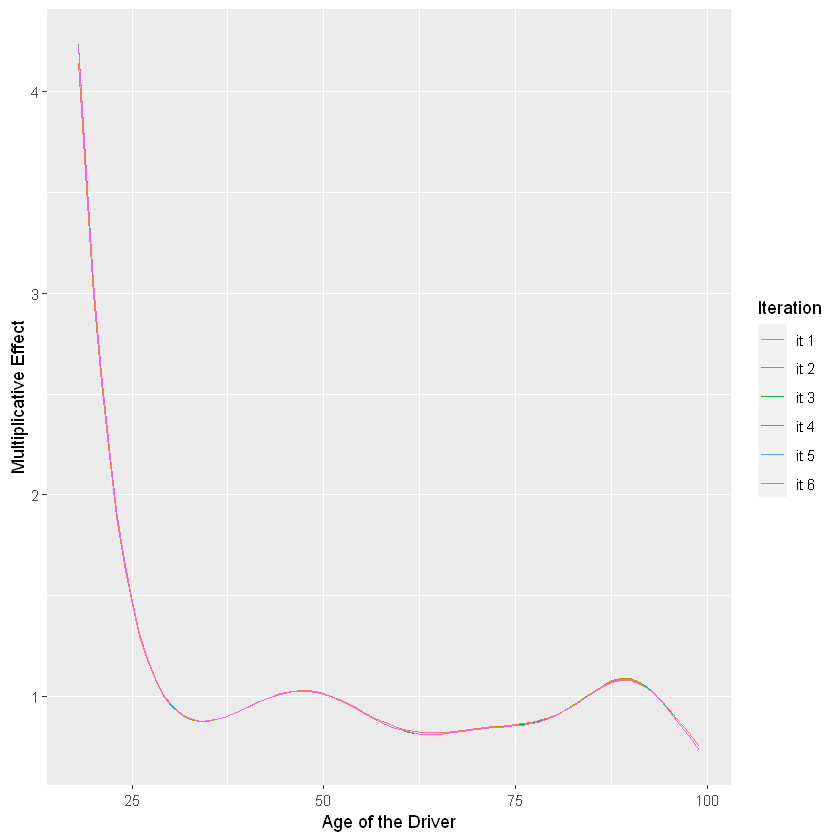

In [22]:
DriverAge = matrix(NA, ncol = 6, nrow = 82)
DriverAge[, 1] = predict(fit_it_DriverAge[[1]], data.frame(DriverAge = seq(from = 18,
    to = 99, by = 1)), type = "response")
DriverAge[, 2] = predict(fit_it_DriverAge[[2]], data.frame(DriverAge = seq(from = 18,
    to = 99, by = 1)), type = "response")
DriverAge[, 3] = predict(fit_it_DriverAge[[3]], data.frame(DriverAge = seq(from = 18,
    to = 99, by = 1)), type = "response")
DriverAge[, 4] = predict(fit_it_DriverAge[[4]], data.frame(DriverAge = seq(from = 18,
    to = 99, by = 1)), type = "response")
DriverAge[, 5] = predict(fit_it_DriverAge[[5]], data.frame(DriverAge = seq(from = 18,
    to = 99, by = 1)), type = "response")
DriverAge[, 6] = predict(fit_it_DriverAge[[6]], data.frame(DriverAge = seq(from = 18,
    to = 99, by = 1)), type = "response")

x = as.data.frame(DriverAge)
names(x) = sapply(1:6, function(i) {
    paste("it", i)
})
x = stack(as.data.frame(x))
names(x)[2] = "Iteration"

ggplot(x) + geom_line(aes(x = rep(18:99, 6), y = values, color = Iteration)) + xlab("Age of the Driver") +
    ylab("Multiplicative Effect")

## Comparison with GAM


Let us now compare with the GAM directly

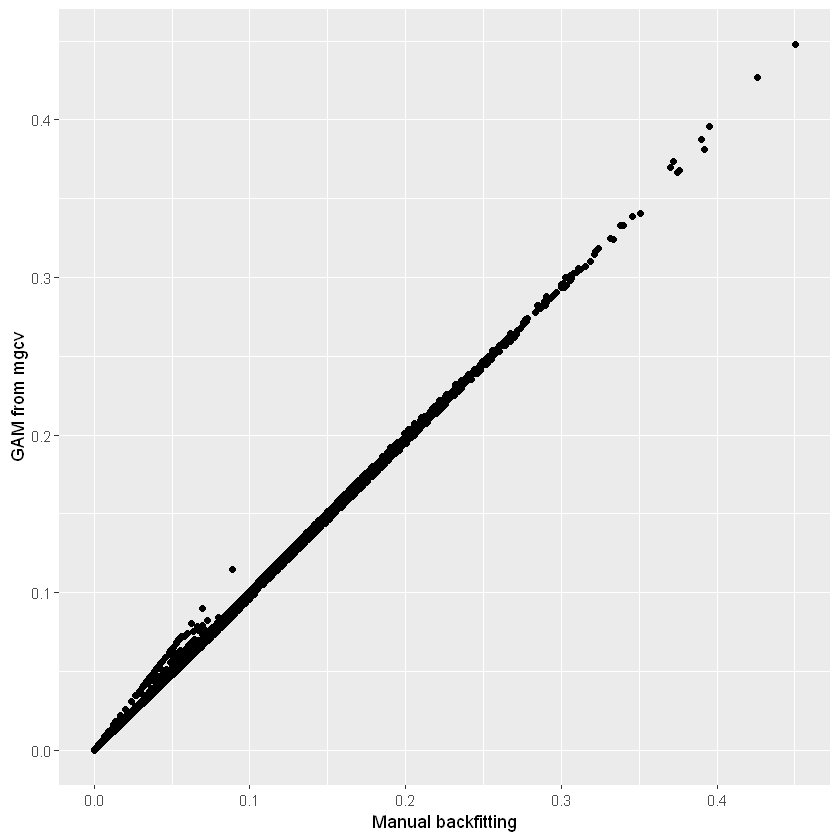

In [23]:
m0_gam = gam(ClaimNb ~ offset(log(Exposure)) + Power * Region + Brand + Gas + s(DriverAge) + s(CarAge), 
             data = autofit,
             family = poisson(link = log))

ggplot() + geom_point(aes(x = autofit$currentfit, y = m0_gam$fitted.values)) + xlab("Manual backfitting") +
    ylab("GAM from mgcv")

# Use of the mgcv package


First, let us retrieve the training and testing set we used before (in the GLM session).



In [24]:
set.seed(21)
in_training = createDataPartition(dataset$ClaimNb, times = 1, p = 0.8, list = FALSE)
training_set = dataset[in_training, ]
testing_set = dataset[-in_training, ]

The gam function works very similarly to the glm function. The continuous covariate have to be specified using for instance the function s(.). Interaction with respect to a discrete variable can be done by specifying the variable in the ‘by’ argument (see below).

## First try with gam


Let us start with the model we created during the GLM session. We will replace the continuous variables by splines.

In [25]:
rec <- recipe(ClaimNb ~ DriverAge + CarAge + Power + Gas + Region + Brand + Exposure, 
              data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    step_mutate(Brand = forcats::fct_collapse(Brand, A = c("Fiat", "Mercedes, Chrysler or BMW", 
                                                     "Opel, General Motors or Ford",
                                                     "other", 
                                                     "Volkswagen, Audi, Skoda or Seat"))) %>%
    step_mutate(Power = forcats::fct_collapse(Power, 
                                                 "e-f-g-h" = c("e", "f", "g", "h"),
                                                 "i-j-k-l-m" = c("i", "j", "k", "l", "m"),
                                                 "n-o" = c("n", "o")
                                                )) %>%
    step_mutate(Region = forcats::fct_collapse(Region, 
                                                 "A" = c("Pays-de-la-Loire", "Poitou-Charentes", "Aquitaine")
                                                )) %>%
    prep()


# Same as above..
ptn_0 = Sys.time()
m0_gam = gam(ClaimNb ~ offset(log(Exposure)) + Power * Region + Brand +
    Gas + s(DriverAge) + s(CarAge), data = bake(rec, training_set),
    family = poisson(link = log))
print(Sys.time() - ptn_0)

Time difference of 2.461797 mins


## Comparison with bam

We see that the computational time is already long, especially if we wanted to use cross-validation. There is also the function bam, which is optimized for very large datasets and allows parallel computing.

In [26]:
require(parallel)
cl = makeCluster(detectCores() - 1)  # Number of cores to use, for parallel computing.
ptn_0 = Sys.time()
m0_bam = bam(ClaimNb ~ offset(log(Exposure)) + Power * Region + Brand +
    Gas+ s(DriverAge) + s(CarAge), data = bake(rec, training_set),
    family = poisson(link = log), cluster = cl)
stopCluster(cl)
print(Sys.time() - ptn_0)

Time difference of 27.91493 secs


We can see the fitted function using plot,

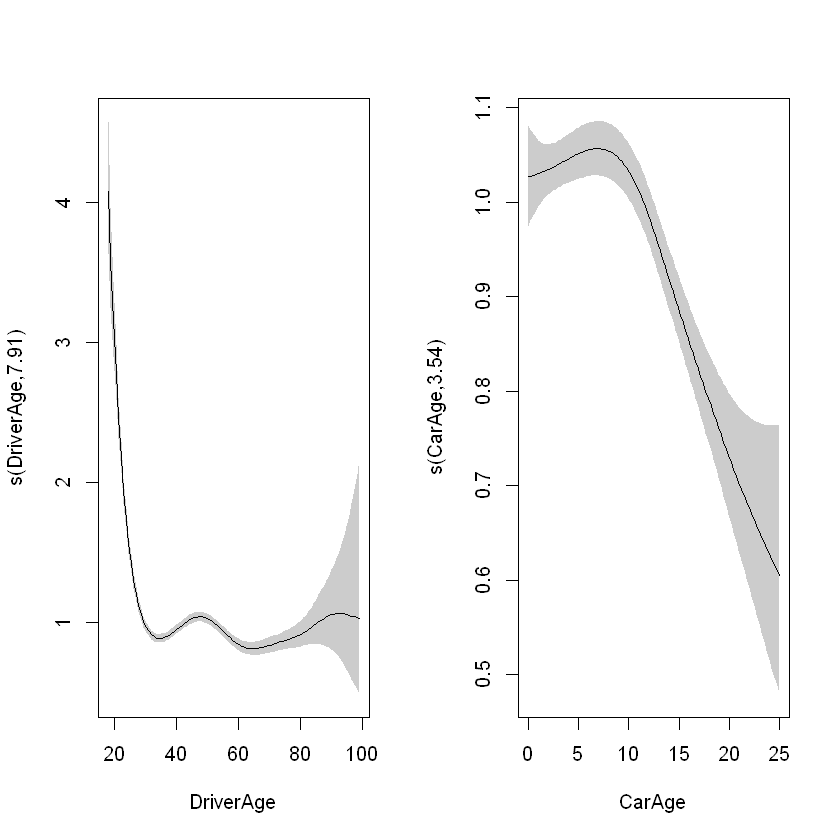

In [27]:
par(mfrow = c(1, 2))
plot(m0_bam, trans = exp, scale = 0, shade = TRUE)

Since 2020, the package mgcViz simplifies greatly the creation of visuals of GAMs. (Vignette available)

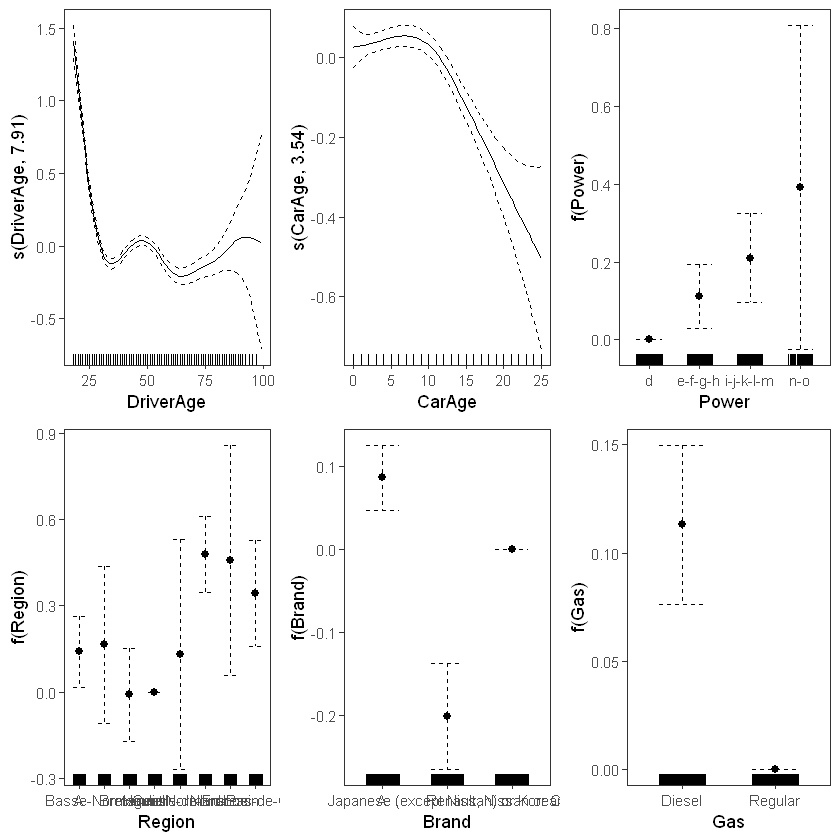

In [31]:
require(mgcViz)
viz <- getViz(m0_bam)
print(plot(viz, allTerms = T), pages = 1)

## Bivariate function


In [32]:
cl = makeCluster(detectCores()-1) # Number of cores to use
m1_bam = bam(ClaimNb ~ offset(log(Exposure)) + Power + Region + Brand + Gas + te(DriverAge, CarAge), # or replace te(DriverAge, CarAge) by ti(DriverAge) + ti(CarAge) + ti(DriverAge, CarAge)
         data = bake(rec, training_set),
         family=poisson(link = log),
         cluster = cl)
stopCluster(cl)
m1_bam


Family: poisson 
Link function: log 

Formula:
ClaimNb ~ offset(log(Exposure)) + Power + Region + Brand + Gas + 
    te(DriverAge, CarAge)

Estimated degrees of freedom:
14.6  total = 28.56 

fREML score: 577639.5     

In [33]:
cl = makeCluster(detectCores()-1) # Number of cores to use
m1_bam_b = bam(ClaimNb ~ offset(log(Exposure)) + offset(log(Exposure)) + Power + Region + Brand + Gas + s(DriverAge, CarAge),
         data = bake(rec, training_set),
         family=poisson(link = log),
         cluster = cl)
stopCluster(cl)
m1_bam_b


Family: poisson 
Link function: log 

Formula:
ClaimNb ~ offset(log(Exposure)) + offset(log(Exposure)) + Power + 
    Region + Brand + Gas + s(DriverAge, CarAge)

Estimated degrees of freedom:
23  total = 37.03 

fREML score: 577751.8     

To choose between te and s when adding bivariate functions, Wood (2017) recommends the following:

- ”Tensor product, te Invariant to linear rescaling of covariates, but not to rotation of covariate space. Good for smooth interactions of quantities measured in different units, or where very different degrees of smoothness appropriate relative to different covariates. Computationally inexpensive, provided TPRS bases are not used as marginal bases. Apart from scale invariance, not much supporting theory.

- TPRS, s(…,bs=“tp”) Invariant to rotation of covariate space (isotropic), but not to rescaling of covariates. Good for smooth interactions of quantities measured in same units, such as spatial co-ordinates, where isotropy is appropriate. Computational cost can be high as it increases with square of number of data (can be avoided by approximation). ”

We can visualize the interactions:

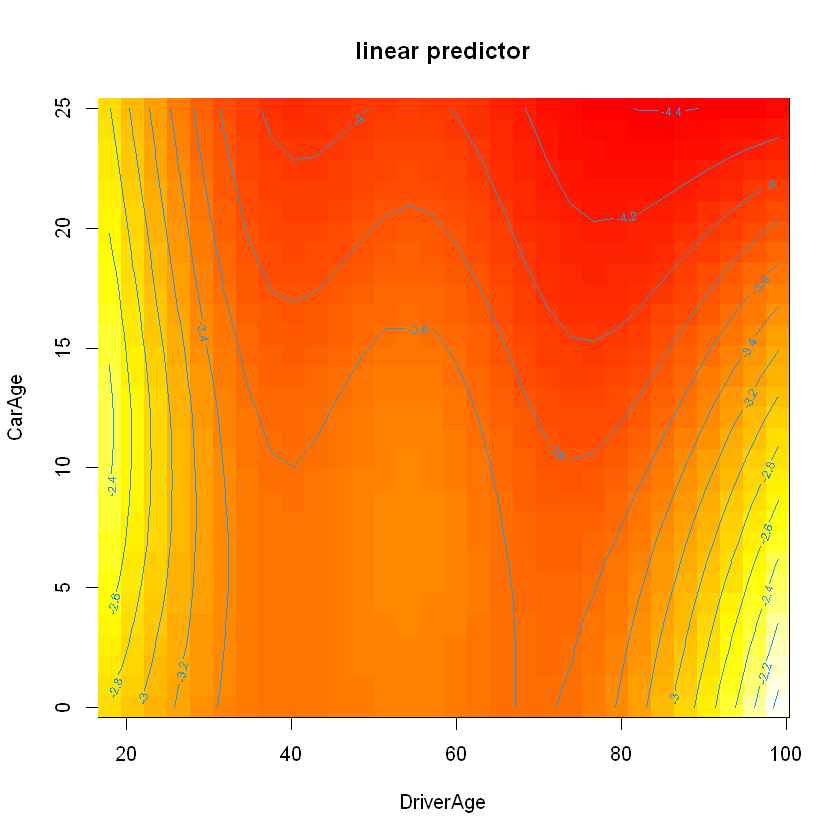

In [34]:
vis.gam(m1_bam, view=c("DriverAge", "CarAge"),  plot.type = 'contour')

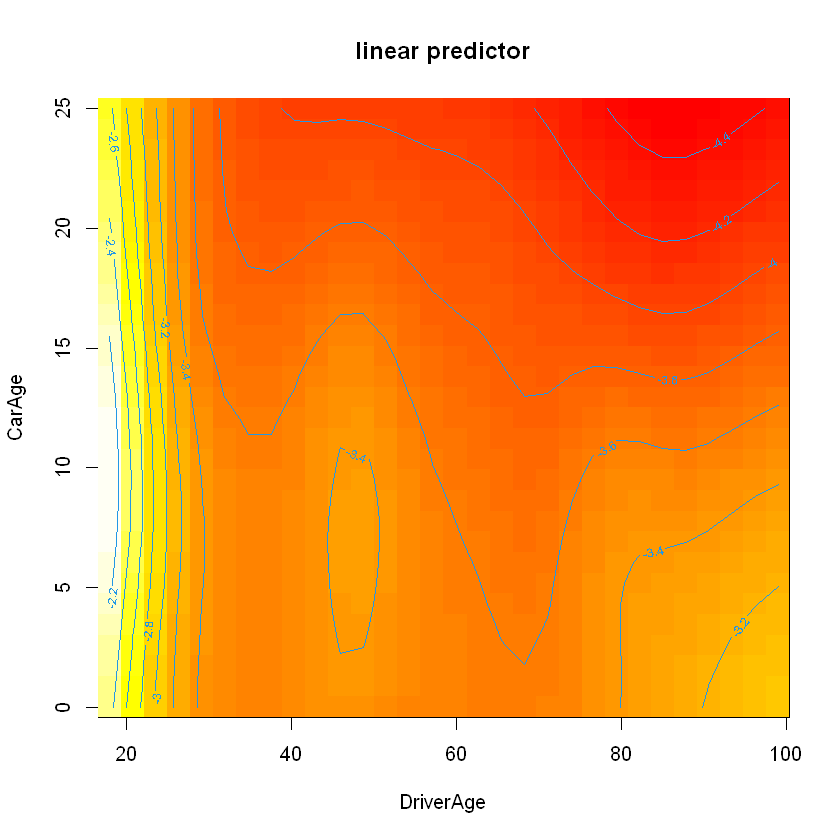

In [35]:
vis.gam(m1_bam_b, view=c("DriverAge", "CarAge"),  plot.type = 'contour')

We can compute the log-likelihood

In [36]:
logLik.gam(m0_bam)

'log Lik.' -54016.41 (df=46.06032)

In [37]:
logLik.gam(m1_bam)

'log Lik.' -54092.17 (df=29.20055)

In [38]:
logLik.gam(m1_bam_b)

'log Lik.' -54013.76 (df=37.25777)

The likelihood ratio test still works like in the GLM framework.

In [39]:
anova(m0_bam, m1_bam_b, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,328644.2,83026.14,NA,NA,NA
2,328651.0,83020.84,-6.817268,5.294707,NA


# Interaction between a continuous and a discrete variable

To include an interaction with a discrete variable, we can use the by argument. For example, between CarAge and Gas:

In [40]:
cl = makeCluster(detectCores() - 1)  # Number of cores to use
m2_bam = bam(ClaimNb ~ offset(log(Exposure)) + Power + Region + Brand + Gas  + s(DriverAge) + s(CarAge, by = Gas), 
             data = bake(rec, training_set),,
    family = poisson(link = log), cluster = cl)
stopCluster(cl)
summary(m2_bam)


Family: poisson 
Link function: log 

Formula:
ClaimNb ~ offset(log(Exposure)) + Power + Region + Brand + Gas + 
    s(DriverAge) + s(CarAge, by = Gas)

Parametric coefficients:
                                        Estimate Std. Error  z value Pr(>|z|)
(Intercept)                             -2.93627    0.02785 -105.417  < 2e-16
Powere-f-g-h                             0.09236    0.02628    3.515  0.00044
Poweri-j-k-l-m                           0.22509    0.03457    6.510 7.50e-11
Powern-o                                 0.29049    0.11133    2.609  0.00907
RegionA                                  0.16598    0.02383    6.967 3.25e-12
RegionBasse-Normandie                    0.08938    0.05392    1.658  0.09735
RegionBretagne                           0.05259    0.02959    1.777  0.07550
RegionHaute-Normandie                    0.12242    0.07690    1.592  0.11137
RegionIle-de-France                      0.37357    0.02856   13.079  < 2e-16
RegionLimousin                           

When we now plot the functions, we obtain two functions for CarAge.

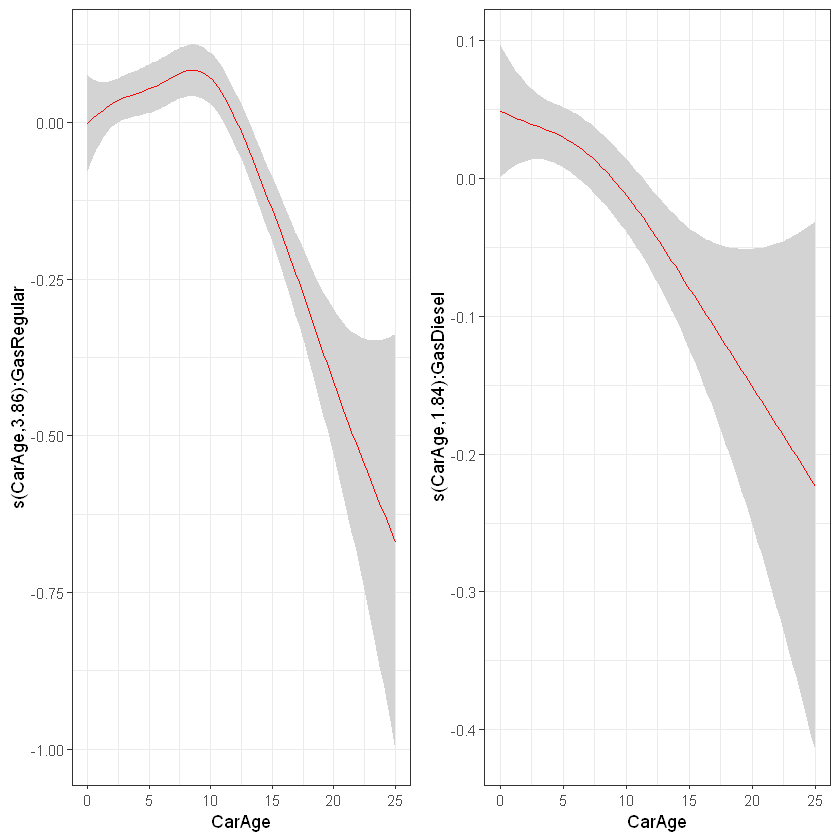

In [41]:
b <- getViz(m2_bam)
gridPrint(plot(sm(b, 2)) + theme_bw() +l_ciPoly()+ l_fitLine(colour = "red"),
          plot(sm(b, 3)) + theme_bw() +l_ciPoly()+ l_fitLine(colour = "red"), ncol=2)

We can test if the interaction improves our model (but does it improve the predictible power of our model ?).

In [42]:
anova(m0_bam, m2_bam, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,328644.2,83026.14,NA,NA,NA
2,328661.2,83035.39,-17.00991,-9.251538,0.9322877


In [43]:
cl = makeCluster(detectCores() - 1)  # Number of cores to use
m3_bam = bam(ClaimNb ~ offset(log(Exposure)) + Power + Region + Brand + Gas + s(DriverAge, by = Gas) + s(CarAge), 
             data = bake(rec, training_set),
    family = poisson(link = log), cluster = cl)
stopCluster(cl)
anova(m0_bam, m3_bam, test = "Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,328644.2,83026.14,NA,NA,NA
2,328656.7,83031.03,-12.54417,-4.888129,0.9712308


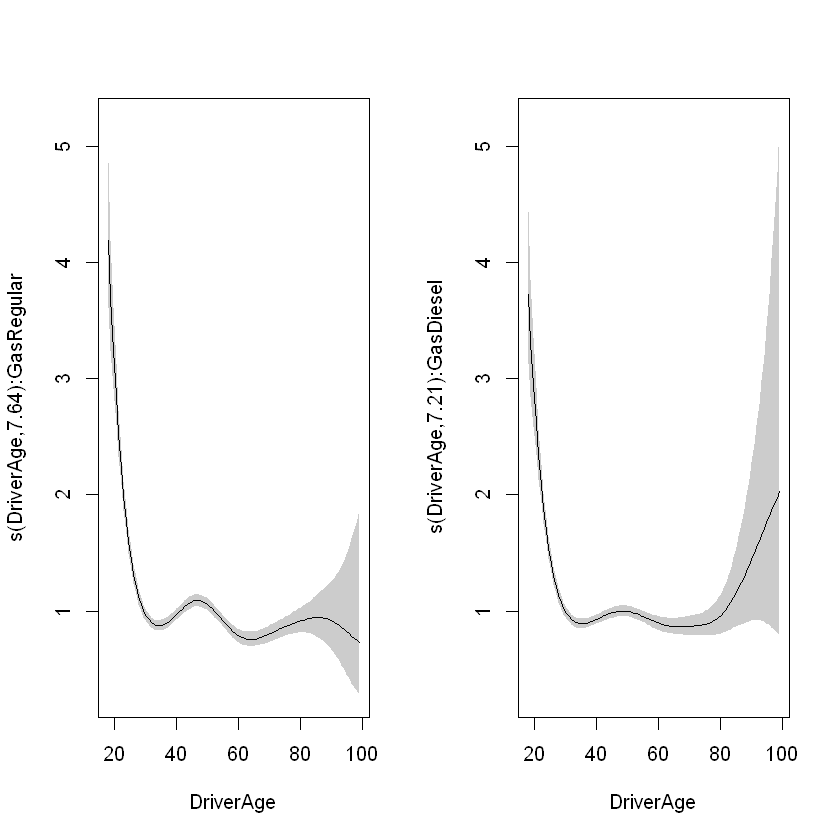

In [44]:
par(mfrow = c(1, 2))
plot(m3_bam, shade = TRUE, trans = exp, scale = -1, select = 1)
plot(m3_bam, shade = TRUE, trans = exp, scale = -1, select = 2)

Or with mgcViz:

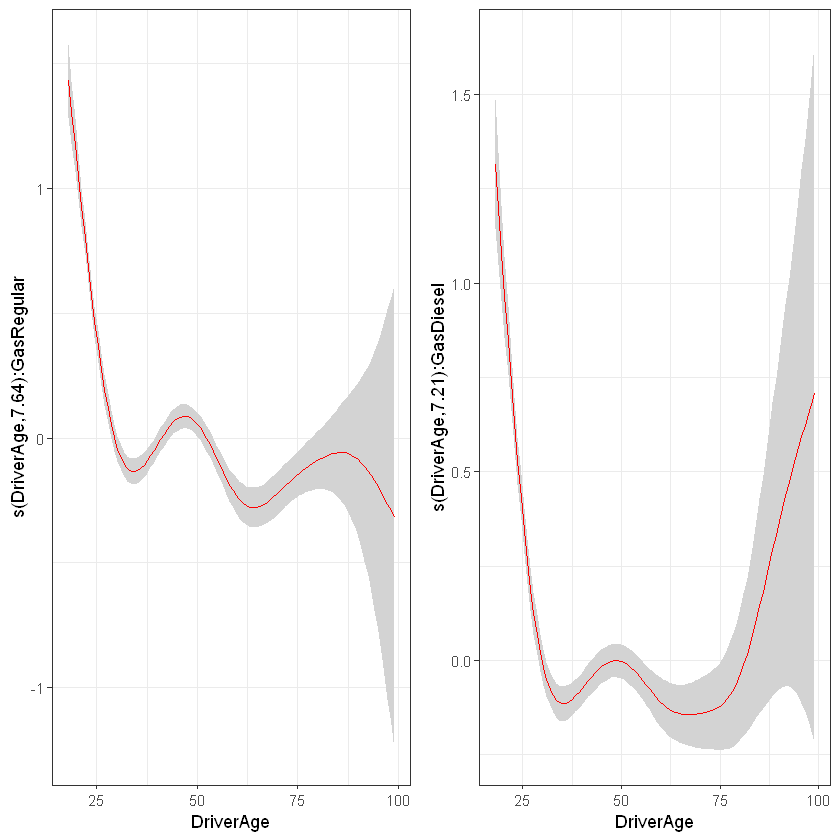

In [45]:
b <- getViz(m3_bam)
gridPrint(plot(sm(b, 1)) + theme_bw() +l_ciPoly()+ l_fitLine(colour = "red"),
          plot(sm(b, 2)) + theme_bw() +l_ciPoly()+ l_fitLine(colour = "red"), ncol=2)

# Cross-validation

We can also use cross-validation to check whether or not to include this variable. First we need to create the folds, let’s say 5.



In [46]:
require(caret)
set.seed(41)
folds = createFolds(training_set$ClaimNb, k = 5)
res0 = lapply(folds, function(X) {
    cl = makeCluster(detectCores() - 1)  # Number of cores to use
    m3_bam = bam(ClaimNb ~ offset(log(Exposure)) + Power + Region + Brand + Gas + s(DriverAge) + s(CarAge),
        data = bake(rec, training_set[-X, ]), family = poisson(link = log), cluster = cl)
    stopCluster(cl)
    pred = predict(m3_bam, bake(rec, training_set[X, ]), type = "response")
    sum(dpois(x = bake(rec, training_set[X, ])$ClaimNb, lambda = pred, log = TRUE))
    # sum(-pred +
    # training_set[X,]$ClaimNb*log(pred)-log(factorial(training_set[X,]$ClaimNb)))
})

res3 = lapply(folds, function(X) {
    cl = makeCluster(detectCores() - 1)  # Number of cores to use
    m3_bam = bam(ClaimNb ~ offset(log(Exposure)) + Power + Region + Brand + Gas + s(DriverAge, by = Gas) +
        s(CarAge), 
                 data = bake(rec, training_set[-X, ]), family = poisson(link = log), cluster = cl)
    stopCluster(cl)
    pred = predict(m3_bam, bake(rec, training_set[X, ]), type = "response")
    sum(dpois(x = bake(rec, training_set[X, ])$ClaimNb, lambda = pred, log = TRUE))
    # sum(-pred +
    # training_set[X,]$ClaimNb*log(pred)-log(factorial(training_set[X,]$ClaimNb)))
})

cbind(unlist(res0), unlist(res3))

Fold1,-10963.91,-10965.52
Fold2,-10512.25,-10511.47
Fold3,-10875.86,-10879.43
Fold4,-10901.66,-10900.27
Fold5,-10803.40,-10802.31


There is no improvement with the interaction.

In [47]:
res4 = lapply(folds, function(X) {
    cl = makeCluster(detectCores() - 1)  # Number of cores to use
    m3_bam = bam(ClaimNb ~ offset(log(Exposure)) + Power + Region + Brand + Gas + s(DriverAge) + s(CarAge, by = Power), 
                 data = bake(rec, training_set[-X, ]), 
                 family = poisson(link = log),
        cluster = cl)
    stopCluster(cl)
    pred = predict(m3_bam, bake(rec, training_set[X, ]), type = "response")
    sum(dpois(x = bake(rec, training_set[X, ])$ClaimNb, lambda = pred, log = TRUE))
    # sum(-pred +
    # training_set[X,]$ClaimNb*log(pred)-log(factorial(training_set[X,]$ClaimNb)))
})
apply(cbind(unlist(res0), unlist(res3), unlist(res4)), 2, mean)

[1] -10811.42 -10811.80 -10812.49

We conclude here, we did not find any further interactions. We can compute the deviance on the validation set

In [48]:
2 * (sum(dpois(x = bake(rec, testing_set)$ClaimNb, lambda = bake(rec, testing_set)$ClaimNb, log = TRUE)) -
    sum(dpois(x = bake(rec, testing_set)$ClaimNb, lambda = predict(m0_bam, bake(rec, testing_set), offset = bake(rec, testing_set)$Exposure,
        type = "response"), log = TRUE)))

[1] 20525.09

# Optimizing the number of nodes

We can also optimize the number of nodes by cross-validation.

In [55]:
res5 = lapply(folds, function(X) {
    cl = makeCluster(detectCores() - 1)  # Number of cores to use
    m3_bam = bam(ClaimNb ~ offset(log(Exposure)) + Power * Region + Brand +
                 Gas+ s(DriverAge, k=15) + s(CarAge), data = bake(rec, training_set[-X,]), 
                 family = poisson(link = log),
                 cluster = cl)
    stopCluster(cl)
    pred = predict(m3_bam, bake(rec, training_set[X, ]), type = "response")
    sum(dpois(x = bake(rec, training_set[X, ])$ClaimNb, lambda = pred, log = TRUE))
    # sum(-pred +
    # training_set[X,]$ClaimNb*log(pred)-log(factorial(training_set[X,]$ClaimNb)))
})
apply(cbind(unlist(res0), unlist(res5)), 2, mean)

[1] -10811.42 -10814.39

# Comparison with best GLM model

In [49]:
rec_glm = recipe(ClaimNb ~ DriverAge + CarAge + Power + Gas + Region + Brand + Exposure, data = training_set) %>% # Which columns do we need ?
    step_relevel(Power, ref_level = "d") %>%
    step_relevel(Gas, ref_level = "Regular") %>%
    step_relevel(Region, ref_level = "Centre") %>%
    step_relevel(Brand, ref_level = "Renault, Nissan or Citroen") %>%
    step_mutate(Brand = forcats::fct_collapse(Brand, A = c("Fiat", "Mercedes, Chrysler or BMW", 
                                                     "Opel, General Motors or Ford",
                                                     "other", 
                                                     "Volkswagen, Audi, Skoda or Seat"))) %>%
    step_mutate(Power = forcats::fct_collapse(Power, 
                                                 "e-f-g-h" = c("e", "f", "g", "h"),
                                                 "i-j-k-l-m" = c("i", "j", "k", "l", "m"),
                                                 "n-o" = c("n", "o")
                                                )) %>%
    step_mutate(Region = forcats::fct_collapse(Region, 
                                                 "A" = c("Pays-de-la-Loire", "Poitou-Charentes", "Aquitaine")
                                                )) %>%
    prep()


m_glm = gam(ClaimNb ~ offset(log(Exposure))+ poly(DriverAge, 7) + poly(CarAge, 2) + Power + Gas + Region + Brand, 
    data = bake(rec_glm, training_set), family = poisson())

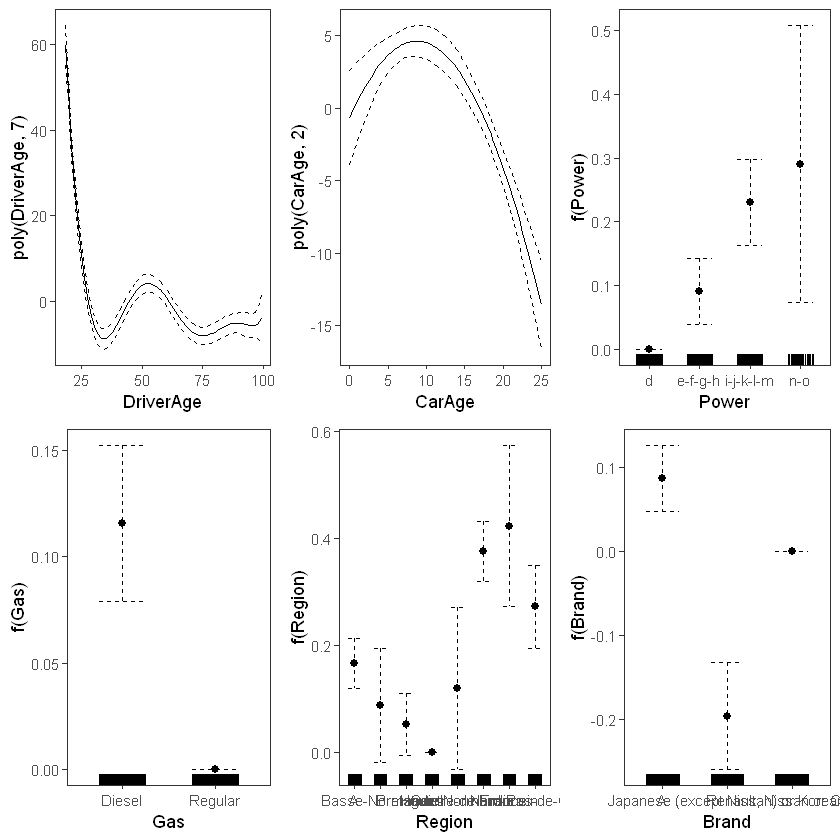

In [50]:
viz <- getViz(m_glm)
print(plot(viz, allTerms = T), pages = 1)

In [51]:
testing_set$GLM_pred = predict(m_glm, bake(rec_glm, testing_set), type="response")
testing_set$GAM_pred = predict(m0_bam, bake(rec, testing_set), type="response")
head(testing_set[,c("GLM_pred", "GAM_pred")], n=5)

,GLM_pred,GAM_pred
,<dbl[1d]>,<dbl[1d]>
1,0.005871975,0.006087387
8,0.003038745,0.003045528
9,0.111069928,0.122687134
14,0.012080838,0.011859629
19,0.009629602,0.009841417


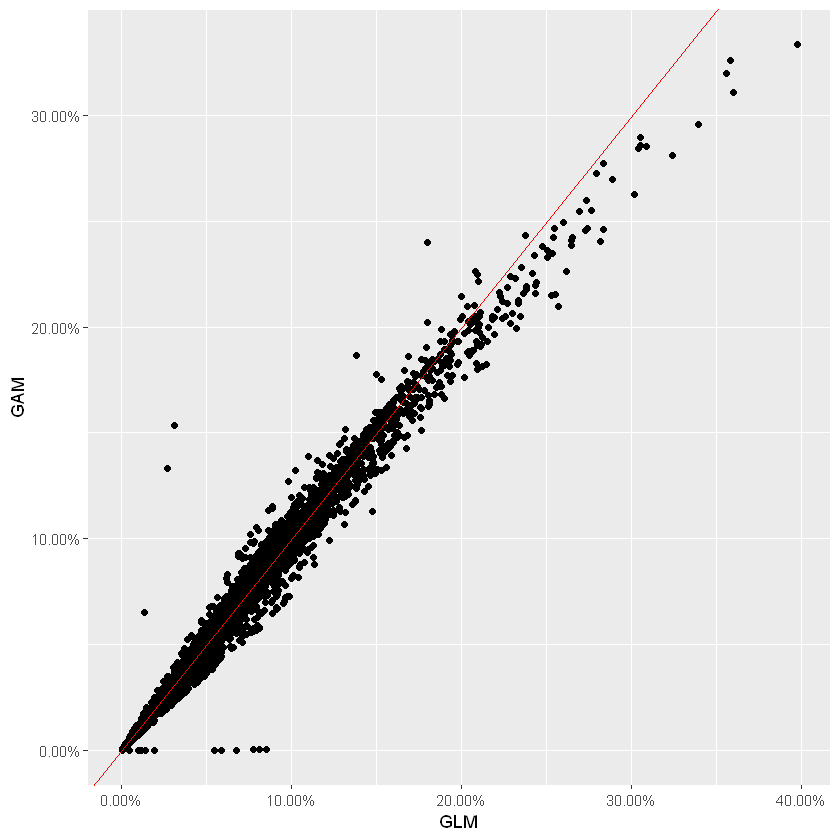

In [52]:
ggplot(testing_set) + geom_point(aes(x=GLM_pred, y=GAM_pred))+ylab("GAM")+xlab("GLM")+geom_abline(slope=1, intercept=0, color="red")+
  scale_x_continuous(labels = scales::percent_format(accuracy = 0.01))+
  scale_y_continuous(labels = scales::percent_format(accuracy = 0.01))

However, the total amount of expected claims are still close.

In [53]:
sum(testing_set$GLM_pred) #GLM

[1] 3215.4

In [54]:
sum(testing_set$GAM_pred) #GAM

[1] 3214.501